In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from torch.autograd import Variable
import torch.nn.functional as F
import numpy as np
from torchvision.utils import make_grid , save_image
# from boltzman_pytorch import *
from tqdm.notebook import tqdm
import os
%matplotlib inline

In [26]:
class RBM(nn.Module):
   def __init__(self,
               n_vis=784,
               n_hin=500,
               k=5):
        super(RBM, self).__init__()
        self.W = nn.Parameter(torch.randn(n_hin,n_vis)*1e-2)
        self.v_bias = nn.Parameter(torch.zeros(n_vis))
        self.h_bias = nn.Parameter(torch.zeros(n_hin))
        self.k = k
    
   def sample_from_p(self,p):
       return F.relu(torch.sign(p - Variable(torch.rand(p.size()))))
    
   def v_to_h(self,v):
        p_h = torch.sigmoid(F.linear(v,self.W,self.h_bias))
        sample_h = self.sample_from_p(p_h)
        return p_h,sample_h
    
   def h_to_v(self,h):
        p_v = torch.sigmoid(F.linear(h,self.W.t(),self.v_bias))
        sample_v = self.sample_from_p(p_v)
        return p_v,sample_v
        
   def forward(self,v):
        pre_h1,h1 = self.v_to_h(v)
        
        h_ = h1
        for _ in range(self.k):
            pre_v_,v_ = self.h_to_v(h_)
            pre_h_,h_ = self.v_to_h(v_)
        
        return v,v_
    
   def free_energy(self,v):
        vbias_term = v.mv(self.v_bias)
        wx_b = F.linear(v,self.W,self.h_bias)
        hidden_term = wx_b.exp().add(1).log().sum(1)
        return (-hidden_term - vbias_term).mean()
   def get_hidden_distribution(self, v: torch.Tensor):
#         v = v.copy_(v).view(v.size()[0],784)
        
        pre_h1,h1 = self.v_to_h(v)
        
        h_ = h1
        for _ in range(self.k):
            pre_v_,v_ = self.h_to_v(h_)
            pre_h_,h_ = self.v_to_h(v_)
            
        return h_

batch_size = 64
train_loader = torch.utils.data.DataLoader(
datasets.MNIST('./data',
    train=True,
    download = True,
    transform = transforms.Compose(
        [transforms.ToTensor()])
     ),
     batch_size=batch_size
)

test_loader = torch.utils.data.DataLoader(
datasets.MNIST('./data',
    train=False,
    transform=transforms.Compose(
    [transforms.ToTensor()])
    ),
    batch_size=batch_size)

rbm_mnist = RBM(k=1)
train_op = optim.SGD(rbm_mnist.parameters(),0.1)


path_mnist = "./saved_models/rbm_mnist_numbers.pth"
if os.path.exists(path_mnist):
    rbm_mnist.load_state_dict(torch.load(path_mnist))
    print("RBM model found")


RBM model found


In [44]:
for epoch in range(20):
    loss_ = []
    for _, (data,target) in tqdm(enumerate(train_loader)):
        data = Variable(data.view(-1,784))
        sample_data = data.bernoulli()
        
        v,v1 = rbm_mnist(sample_data)
        loss = rbm_mnist.free_energy(v) - rbm_mnist.free_energy(v1)
        loss_.append(loss.data)
        train_op.zero_grad()
        loss.backward()
        train_op.step()

    print("Training loss for {} epoch: {}".format(epoch, np.mean(loss_)))
    
torch.save(rbm_mnist.state_dict(), path_mnist)

0it [00:00, ?it/s]

Training loss for 0 epoch: 1.1977107524871826


0it [00:00, ?it/s]

Training loss for 1 epoch: 1.1851824522018433


0it [00:00, ?it/s]

Training loss for 2 epoch: 1.183665156364441


0it [00:00, ?it/s]

Training loss for 3 epoch: 1.206178069114685


0it [00:00, ?it/s]

Training loss for 4 epoch: 1.1545995473861694


0it [00:00, ?it/s]

Training loss for 5 epoch: 1.1574219465255737


0it [00:00, ?it/s]

Training loss for 6 epoch: 1.1739757061004639


0it [00:00, ?it/s]

Training loss for 7 epoch: 1.2359868288040161


0it [00:00, ?it/s]

Training loss for 8 epoch: 1.1649152040481567


0it [00:00, ?it/s]

Training loss for 9 epoch: 1.181788682937622


0it [00:00, ?it/s]

Training loss for 10 epoch: 1.2469512224197388


0it [00:00, ?it/s]

Training loss for 11 epoch: 1.1570346355438232


0it [00:00, ?it/s]

Training loss for 12 epoch: 1.19570791721344


0it [00:00, ?it/s]

Training loss for 13 epoch: 1.2632192373275757


0it [00:00, ?it/s]

Training loss for 14 epoch: 1.195389747619629


0it [00:00, ?it/s]

Training loss for 15 epoch: 1.2045854330062866


0it [00:00, ?it/s]

Training loss for 16 epoch: 1.142187237739563


0it [00:00, ?it/s]

Training loss for 17 epoch: 1.2085016965866089


0it [00:00, ?it/s]

Training loss for 18 epoch: 1.1853317022323608


0it [00:00, ?it/s]

Training loss for 19 epoch: 1.2230384349822998


In [8]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = RBM(k = 1)
loss_fn = nn.L1Loss()
optimizer = optim.SGD(model.parameters(), lr = 0.1)
loss_fn.to(device)
model.to(device)
print(device)

cuda


In [8]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((28, 28)),
    transforms.Grayscale()
])
handwritten_data = torchvision.datasets.ImageFolder("./data/handwrittendataset/Train/", transform)
test_data = torchvision.datasets.ImageFolder("./data/handwrittendataset/Test/", transform)
batch_size = 512
dataloader = torch.utils.data.DataLoader(dataset=handwritten_data, batch_size = batch_size, shuffle = True)
test_dataloader = torch.utils.data.DataLoader(dataset=test_data, batch_size = 4, shuffle = True)

In [7]:
import os
rbm = RBM(784, 500, k = 1)
loss_fn = nn.L1Loss()
optimizer = optim.SGD(rbm.parameters(), lr = 0.1)
# rbm.to(device)
path = "./saved_models/rbm_nepali_characters.pth"
if os.path.exists(path):
    rbm.load_state_dict(torch.load(path))
    print("RBM model found")

RBM model found


In [26]:
loss_boltzman = np.array([])
for epoch in range(100):
    loss_ = []
    for i, (data,target) in tqdm(enumerate(dataloader)):
        data = Variable(data.view((-1 ,784)))
        sample_data = data.bernoulli()
        
        v,v1 = rbm(sample_data)
        loss = loss_fn(rbm.free_energy(v), rbm.free_energy(v1))
#         loss = rbm.free_energy(v) - rbm.free_energy(v1)
        loss_.append(loss.data)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if i % 100 == 0:
            print("Training loss for {} epoch: {}".format(epoch, np.mean(loss_)))
            
    print(f"Total Data = {i}")
            
    loss_boltzman = np.append(loss_boltzman, np.mean(loss_))
    with open("loss.csv", 'a') as f:
        f.write(f"Loss, {np.mean(loss_):4f}\n")

0it [00:00, ?it/s]

Training loss for 0 epoch: 1.2983665466308594
Training loss for 0 epoch: 1.3327977657318115
Total Data = 152


0it [00:00, ?it/s]

Training loss for 1 epoch: 0.3275032043457031
Training loss for 1 epoch: 1.2775014638900757
Total Data = 152


0it [00:00, ?it/s]

Training loss for 2 epoch: 0.2294178009033203
Training loss for 2 epoch: 1.4102030992507935
Total Data = 152


0it [00:00, ?it/s]

Training loss for 3 epoch: 1.6608161926269531
Training loss for 3 epoch: 1.3378022909164429
Total Data = 152


0it [00:00, ?it/s]

Training loss for 4 epoch: 1.0532646179199219
Training loss for 4 epoch: 1.268917441368103
Total Data = 152


0it [00:00, ?it/s]

Training loss for 5 epoch: 0.21120834350585938
Training loss for 5 epoch: 1.3424146175384521
Total Data = 152


0it [00:00, ?it/s]

Training loss for 6 epoch: 1.0897331237792969
Training loss for 6 epoch: 1.2440259456634521
Total Data = 152


0it [00:00, ?it/s]

Training loss for 7 epoch: 1.4898319244384766
Training loss for 7 epoch: 1.2282016277313232
Total Data = 152


0it [00:00, ?it/s]

Training loss for 8 epoch: 1.1719989776611328
Training loss for 8 epoch: 1.3225932121276855
Total Data = 152


0it [00:00, ?it/s]

Training loss for 9 epoch: 1.0139293670654297
Training loss for 9 epoch: 1.1713446378707886
Total Data = 152


0it [00:00, ?it/s]

Training loss for 10 epoch: 0.3001289367675781
Training loss for 10 epoch: 1.1772688627243042
Total Data = 152


0it [00:00, ?it/s]

Training loss for 11 epoch: 0.06297111511230469
Training loss for 11 epoch: 1.153537392616272
Total Data = 152


0it [00:00, ?it/s]

Training loss for 12 epoch: 0.328125
Training loss for 12 epoch: 1.077643632888794
Total Data = 152


0it [00:00, ?it/s]

Training loss for 13 epoch: 1.2352771759033203
Training loss for 13 epoch: 1.0554656982421875
Total Data = 152


0it [00:00, ?it/s]

Training loss for 14 epoch: 0.7020931243896484
Training loss for 14 epoch: 1.0315806865692139
Total Data = 152


0it [00:00, ?it/s]

Training loss for 15 epoch: 0.3229942321777344
Training loss for 15 epoch: 1.0838149785995483
Total Data = 152


0it [00:00, ?it/s]

Training loss for 16 epoch: 0.24023056030273438
Training loss for 16 epoch: 1.133874535560608
Total Data = 152


0it [00:00, ?it/s]

Training loss for 17 epoch: 0.34349632263183594
Training loss for 17 epoch: 1.0967979431152344
Total Data = 152


0it [00:00, ?it/s]

Training loss for 18 epoch: 1.1120529174804688
Training loss for 18 epoch: 0.9762647151947021
Total Data = 152


0it [00:00, ?it/s]

Training loss for 19 epoch: 2.1405563354492188
Training loss for 19 epoch: 1.1034886837005615
Total Data = 152


0it [00:00, ?it/s]

Training loss for 20 epoch: 1.0142822265625
Training loss for 20 epoch: 0.9030298590660095
Total Data = 152


0it [00:00, ?it/s]

Training loss for 21 epoch: 2.250173568725586
Training loss for 21 epoch: 0.9742867350578308
Total Data = 152


0it [00:00, ?it/s]

Training loss for 22 epoch: 1.0147571563720703
Training loss for 22 epoch: 0.9923795461654663
Total Data = 152


0it [00:00, ?it/s]

Training loss for 23 epoch: 0.10428810119628906
Training loss for 23 epoch: 0.9882625341415405
Total Data = 152


0it [00:00, ?it/s]

Training loss for 24 epoch: 0.4740276336669922
Training loss for 24 epoch: 0.9092955589294434
Total Data = 152


0it [00:00, ?it/s]

Training loss for 25 epoch: 0.7971649169921875
Training loss for 25 epoch: 0.8985636234283447
Total Data = 152


0it [00:00, ?it/s]

Training loss for 26 epoch: 0.33802032470703125
Training loss for 26 epoch: 0.8869608044624329
Total Data = 152


0it [00:00, ?it/s]

Training loss for 27 epoch: 0.7720584869384766
Training loss for 27 epoch: 0.9989140629768372
Total Data = 152


0it [00:00, ?it/s]

Training loss for 28 epoch: 0.5644721984863281
Training loss for 28 epoch: 0.9187678098678589
Total Data = 152


0it [00:00, ?it/s]

Training loss for 29 epoch: 0.460723876953125
Training loss for 29 epoch: 0.909466028213501
Total Data = 152


0it [00:00, ?it/s]

Training loss for 30 epoch: 0.017477035522460938
Training loss for 30 epoch: 0.8487222790718079
Total Data = 152


0it [00:00, ?it/s]

Training loss for 31 epoch: 0.1228179931640625
Training loss for 31 epoch: 0.9255236387252808
Total Data = 152


0it [00:00, ?it/s]

Training loss for 32 epoch: 1.044586181640625
Training loss for 32 epoch: 0.8015092611312866
Total Data = 152


0it [00:00, ?it/s]

Training loss for 33 epoch: 0.2255687713623047
Training loss for 33 epoch: 0.8785450458526611
Total Data = 152


0it [00:00, ?it/s]

Training loss for 34 epoch: 0.27100563049316406
Training loss for 34 epoch: 0.8222015500068665
Total Data = 152


0it [00:00, ?it/s]

Training loss for 35 epoch: 1.3229961395263672
Training loss for 35 epoch: 0.8667036294937134
Total Data = 152


0it [00:00, ?it/s]

Training loss for 36 epoch: 1.3605899810791016
Training loss for 36 epoch: 0.8440372943878174
Total Data = 152


0it [00:00, ?it/s]

Training loss for 37 epoch: 1.873067855834961
Training loss for 37 epoch: 0.8705648183822632
Total Data = 152


0it [00:00, ?it/s]

Training loss for 38 epoch: 0.09371376037597656
Training loss for 38 epoch: 0.9534832835197449
Total Data = 152


0it [00:00, ?it/s]

Training loss for 39 epoch: 0.5416469573974609
Training loss for 39 epoch: 0.7603438496589661
Total Data = 152


0it [00:00, ?it/s]

Training loss for 40 epoch: 0.4343891143798828
Training loss for 40 epoch: 0.8230026364326477
Total Data = 152


0it [00:00, ?it/s]

Training loss for 41 epoch: 1.47406005859375
Training loss for 41 epoch: 0.8448916673660278
Total Data = 152


0it [00:00, ?it/s]

Training loss for 42 epoch: 0.1267414093017578
Training loss for 42 epoch: 0.7701076865196228
Total Data = 152


0it [00:00, ?it/s]

Training loss for 43 epoch: 0.9998283386230469
Training loss for 43 epoch: 0.8661208748817444
Total Data = 152


0it [00:00, ?it/s]

Training loss for 44 epoch: 0.05513954162597656
Training loss for 44 epoch: 0.8424861431121826
Total Data = 152


0it [00:00, ?it/s]

Training loss for 45 epoch: 0.07662773132324219
Training loss for 45 epoch: 0.8058292865753174
Total Data = 152


0it [00:00, ?it/s]

Training loss for 46 epoch: 0.12455940246582031
Training loss for 46 epoch: 0.6882005333900452
Total Data = 152


0it [00:00, ?it/s]

Training loss for 47 epoch: 0.9759941101074219
Training loss for 47 epoch: 0.9597088694572449
Total Data = 152


0it [00:00, ?it/s]

Training loss for 48 epoch: 2.669849395751953
Training loss for 48 epoch: 0.7707827091217041
Total Data = 152


0it [00:00, ?it/s]

Training loss for 49 epoch: 1.8587455749511719
Training loss for 49 epoch: 0.8927275538444519
Total Data = 152


0it [00:00, ?it/s]

Training loss for 50 epoch: 2.637523651123047
Training loss for 50 epoch: 0.9047866463661194
Total Data = 152


0it [00:00, ?it/s]

Training loss for 51 epoch: 2.0676727294921875
Training loss for 51 epoch: 0.770128607749939
Total Data = 152


0it [00:00, ?it/s]

Training loss for 52 epoch: 1.3384780883789062
Training loss for 52 epoch: 0.8407078981399536
Total Data = 152


0it [00:00, ?it/s]

Training loss for 53 epoch: 1.0548210144042969
Training loss for 53 epoch: 0.8306818008422852
Total Data = 152


0it [00:00, ?it/s]

Training loss for 54 epoch: 0.90771484375
Training loss for 54 epoch: 0.7729290723800659
Total Data = 152


0it [00:00, ?it/s]

Training loss for 55 epoch: 0.3229026794433594
Training loss for 55 epoch: 0.665688693523407
Total Data = 152


0it [00:00, ?it/s]

Training loss for 56 epoch: 0.3198223114013672
Training loss for 56 epoch: 0.8345521092414856
Total Data = 152


0it [00:00, ?it/s]

Training loss for 57 epoch: 1.679962158203125
Training loss for 57 epoch: 0.7534560561180115
Total Data = 152


0it [00:00, ?it/s]

Training loss for 58 epoch: 0.32937049865722656
Training loss for 58 epoch: 0.7092623710632324
Total Data = 152


0it [00:00, ?it/s]

Training loss for 59 epoch: 1.5828857421875
Training loss for 59 epoch: 0.7645343542098999
Total Data = 152


0it [00:00, ?it/s]

Training loss for 60 epoch: 0.2712135314941406
Training loss for 60 epoch: 0.7197622060775757
Total Data = 152


0it [00:00, ?it/s]

Training loss for 61 epoch: 1.6549530029296875
Training loss for 61 epoch: 0.7496679425239563
Total Data = 152


0it [00:00, ?it/s]

Training loss for 62 epoch: 0.23662185668945312
Training loss for 62 epoch: 0.7704806327819824
Total Data = 152


0it [00:00, ?it/s]

Training loss for 63 epoch: 0.5090980529785156
Training loss for 63 epoch: 0.7650238871574402
Total Data = 152


0it [00:00, ?it/s]

Training loss for 64 epoch: 0.6788330078125
Training loss for 64 epoch: 0.8479461669921875
Total Data = 152


0it [00:00, ?it/s]

Training loss for 65 epoch: 1.3712272644042969
Training loss for 65 epoch: 0.8100609183311462
Total Data = 152


0it [00:00, ?it/s]

Training loss for 66 epoch: 0.8586196899414062
Training loss for 66 epoch: 0.8055374622344971
Total Data = 152


0it [00:00, ?it/s]

Training loss for 67 epoch: 0.5186576843261719
Training loss for 67 epoch: 0.8113768696784973
Total Data = 152


0it [00:00, ?it/s]

Training loss for 68 epoch: 0.85009765625
Training loss for 68 epoch: 0.8174176216125488
Total Data = 152


0it [00:00, ?it/s]

Training loss for 69 epoch: 1.5098857879638672
Training loss for 69 epoch: 0.7248178124427795
Total Data = 152


0it [00:00, ?it/s]

Training loss for 70 epoch: 0.4107627868652344
Training loss for 70 epoch: 0.7694084048271179
Total Data = 152


0it [00:00, ?it/s]

Training loss for 71 epoch: 0.27239227294921875
Training loss for 71 epoch: 0.8698214292526245
Total Data = 152


0it [00:00, ?it/s]

Training loss for 72 epoch: 0.2061176300048828
Training loss for 72 epoch: 0.7559489607810974
Total Data = 152


0it [00:00, ?it/s]

Training loss for 73 epoch: 0.7320365905761719
Training loss for 73 epoch: 0.7804328203201294
Total Data = 152


0it [00:00, ?it/s]

Training loss for 74 epoch: 1.664419174194336
Training loss for 74 epoch: 0.7746495008468628
Total Data = 152


0it [00:00, ?it/s]

Training loss for 75 epoch: 0.242767333984375
Training loss for 75 epoch: 0.7750372290611267
Total Data = 152


0it [00:00, ?it/s]

Training loss for 76 epoch: 0.4632110595703125
Training loss for 76 epoch: 0.8437013626098633
Total Data = 152


0it [00:00, ?it/s]

Training loss for 77 epoch: 1.6095123291015625
Training loss for 77 epoch: 0.8382073044776917
Total Data = 152


0it [00:00, ?it/s]

Training loss for 78 epoch: 1.06646728515625
Training loss for 78 epoch: 0.7782000303268433
Total Data = 152


0it [00:00, ?it/s]

Training loss for 79 epoch: 0.3691215515136719
Training loss for 79 epoch: 0.7943506240844727
Total Data = 152


0it [00:00, ?it/s]

Training loss for 80 epoch: 0.23411178588867188
Training loss for 80 epoch: 0.8094258308410645
Total Data = 152


0it [00:00, ?it/s]

Training loss for 81 epoch: 0.27294158935546875
Training loss for 81 epoch: 0.8738185167312622
Total Data = 152


0it [00:00, ?it/s]

Training loss for 82 epoch: 1.7015914916992188
Training loss for 82 epoch: 0.7566732168197632
Total Data = 152


0it [00:00, ?it/s]

Training loss for 83 epoch: 0.2414398193359375
Training loss for 83 epoch: 0.8839190602302551
Total Data = 152


0it [00:00, ?it/s]

Training loss for 84 epoch: 0.14642333984375
Training loss for 84 epoch: 0.8610679507255554
Total Data = 152


0it [00:00, ?it/s]

Training loss for 85 epoch: 2.469411849975586
Training loss for 85 epoch: 0.9248227477073669
Total Data = 152


0it [00:00, ?it/s]

Training loss for 86 epoch: 0.16338348388671875
Training loss for 86 epoch: 0.7055336236953735
Total Data = 152


0it [00:00, ?it/s]

Training loss for 87 epoch: 1.0397796630859375
Training loss for 87 epoch: 0.841901421546936
Total Data = 152


0it [00:00, ?it/s]

Training loss for 88 epoch: 1.9220123291015625
Training loss for 88 epoch: 0.9029685854911804
Total Data = 152


0it [00:00, ?it/s]

Training loss for 89 epoch: 1.7516803741455078
Training loss for 89 epoch: 0.7506408095359802
Total Data = 152


0it [00:00, ?it/s]

Training loss for 90 epoch: 2.579761505126953
Training loss for 90 epoch: 0.7428379058837891
Total Data = 152


0it [00:00, ?it/s]

Training loss for 91 epoch: 1.1963157653808594
Training loss for 91 epoch: 0.7462109923362732
Total Data = 152


0it [00:00, ?it/s]

Training loss for 92 epoch: 0.7275810241699219
Training loss for 92 epoch: 0.7731672525405884
Total Data = 152


0it [00:00, ?it/s]

Training loss for 93 epoch: 1.7945365905761719
Training loss for 93 epoch: 0.7768507599830627
Total Data = 152


0it [00:00, ?it/s]

Training loss for 94 epoch: 0.04312896728515625
Training loss for 94 epoch: 0.7802541851997375
Total Data = 152


0it [00:00, ?it/s]

Training loss for 95 epoch: 0.25527191162109375
Training loss for 95 epoch: 0.8059903979301453
Total Data = 152


0it [00:00, ?it/s]

Training loss for 96 epoch: 0.43121337890625
Training loss for 96 epoch: 0.8012270927429199
Total Data = 152


0it [00:00, ?it/s]

Training loss for 97 epoch: 0.03223419189453125
Training loss for 97 epoch: 0.7633741497993469
Total Data = 152


0it [00:00, ?it/s]

Training loss for 98 epoch: 1.6450271606445312
Training loss for 98 epoch: 0.8126160502433777
Total Data = 152


0it [00:00, ?it/s]

Training loss for 99 epoch: 0.5050735473632812
Training loss for 99 epoch: 0.7958899736404419
Total Data = 152


In [8]:
def show_adn_save(file_name,img):
    npimg = np.transpose(img.numpy(),(1,2,0))
    f = "./%s.png" % file_name
    plt.imshow(npimg)
    plt.imsave(f,npimg)

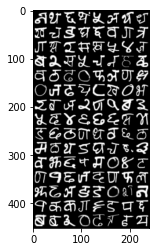

In [18]:
show_adn_save("real",make_grid(data.view(data.size()[0],1,28,28).data))

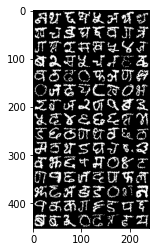

In [19]:
show_adn_save("real",make_grid(v.view(v1.size()[0],1,28,28).data))

In [29]:
torch.save(rbm.state_dict(), "saved_models/rbm_nepali_characters.pth")

## Checking Outputs

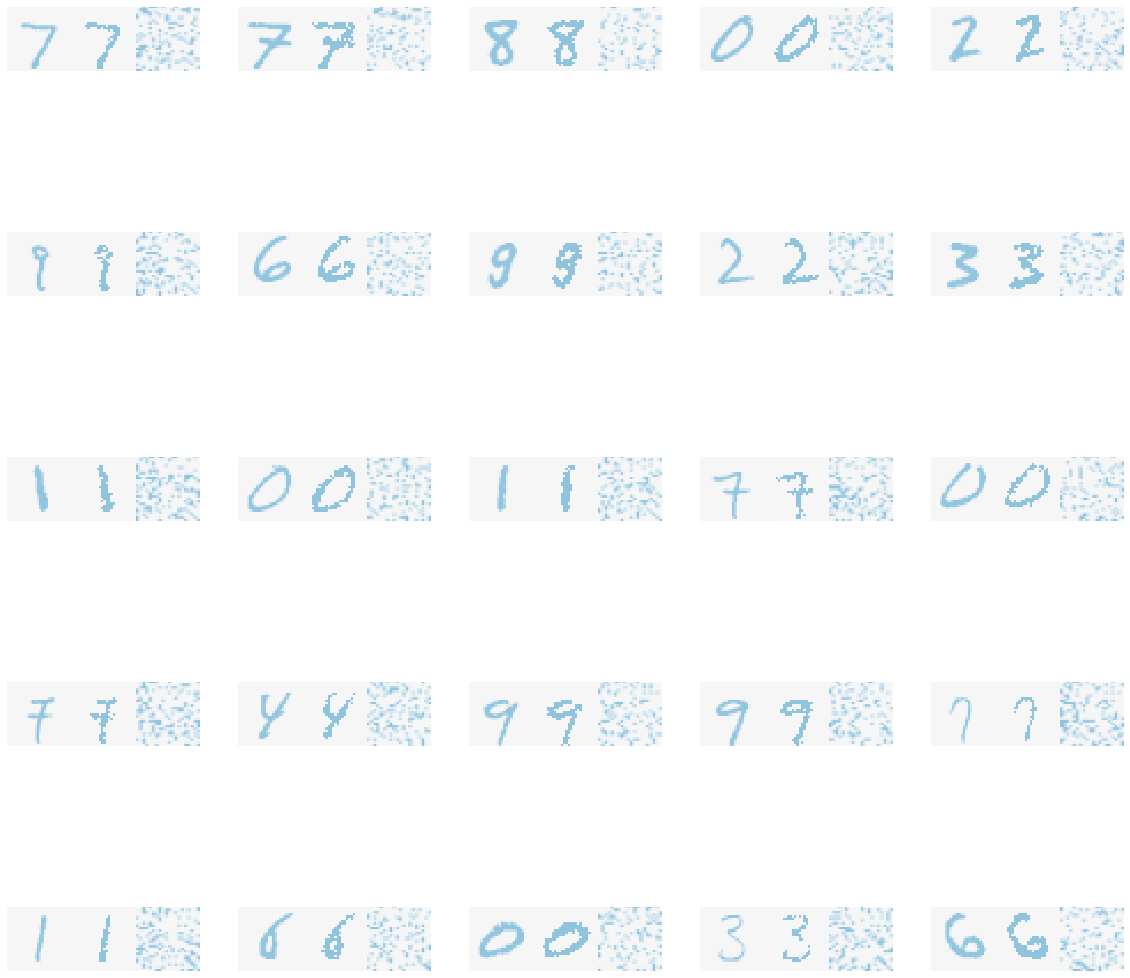

In [37]:
plt.figure(figsize=(20, 20))

for i, (data, target) in enumerate(test_loader):
    plt.subplot(5, 5, i + 1)
    
    image_width = 28
    image_height = 28
    image_transform = transforms.Compose([
        transforms.Resize((image_width, image_height))
    ])
    image_1 = data[0].view((28, 28))
    image_2 = rbm_mnist.forward(data[0].view(784))[1].view((28, 28))
    image_3 = image_transform(torch.reshape(
        rbm_mnist.get_hidden_distribution(data[0].view(784)), (25, 20)).unsqueeze(0))[0]
#     print(f"{image_1.shape}, {image_2.shape}")
    image_show = torch.cat(
        (image_1, image_2, image_3),
        1
    )
#     plt.imshow(data[0].view(28, 28).detach().cpu().numpy(), cmap=plt.cm.RdBu,
#                interpolation='nearest', vmin=-2.5, vmax=2.5)
#     plt.subplot(10, 20, i + 1)
#     plt.imshow(rbm.forward(data[0].view(784))[0].view((28, 28)).detach().cpu().numpy(), cmap=plt.cm.RdBu,
#                interpolation='nearest', vmin=-2.5, vmax=2.5)
    plt.imshow(image_show.detach().cpu().numpy(), cmap=plt.cm.RdBu,
               interpolation='nearest', vmin=-2.5, vmax=2.5)
    plt.axis('off')
    
    if i >= 24:
        break

plt.savefig("output.png")
plt.show()